<a href="https://colab.research.google.com/github/shabana1408/Prediction-of-Product-Sales/blob/main/Prediction_of_Product_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of Product Sales

- Author: `Shabana Patel`

## Project Overview

Sales prediction for food items sold at various stores.
The goal of this project is to help the retailer understand the properties of products and outlets that play crucial roles in increasing sales.

## Data Source

[Original source](https:/https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/)

## Data Dictionary

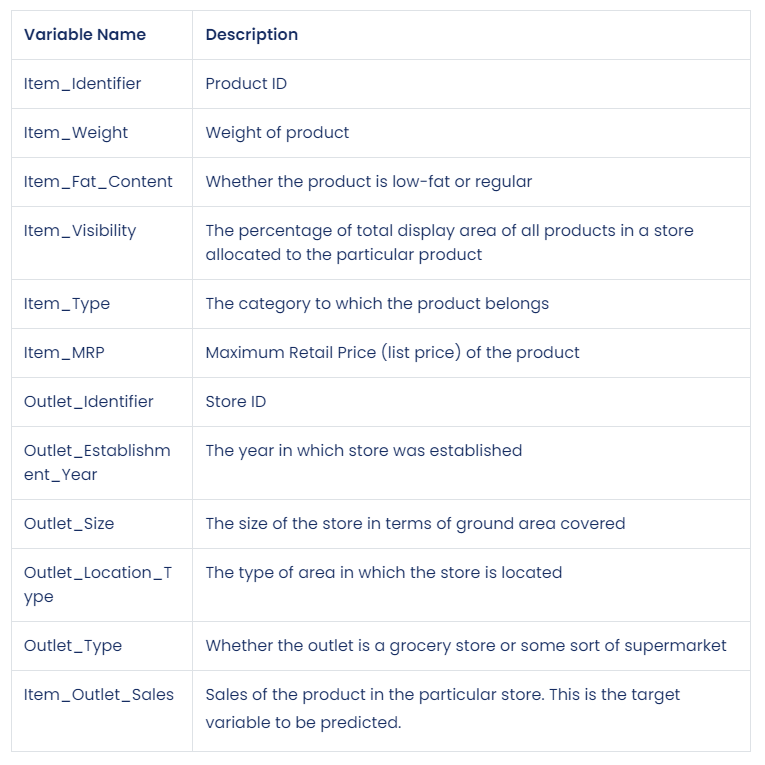

## Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

set_config(transform_output='pandas')

plt.style.use(['dark_background','seaborn-v0_8-notebook'])

## Custom Functions

In [7]:
def create_numeric_graphs(df, inp_x):

  fig, axes = plt.subplots(nrows=2, figsize=(10,5), sharex=True);

  sns.histplot(data=df,x = inp_x,ax = axes[0]);

  mean_value = df[inp_x].mean()
  axes[0].axvline(mean_value, color='white', ls='dashed', label=f'Mean: {mean_value:.2f}');
  axes[1].axvline(mean_value, color='white', ls='dashed', label=f'Mean: {mean_value:.2f}');

  med_value = df[inp_x].median()
  axes[0].axvline(med_value, color='grey', ls='solid', label=f'Median: {med_value:.2f}');
  axes[1].axvline(med_value, color='grey', ls='solid', label=f'Median: {med_value:.2f}');

  sns.boxplot(data=df, x = inp_x, ax = axes[1]);

  axes[0].set_title(f'EDA: {inp_x}', fontdict={'fontsize':10});

  axes[0].legend()
  plt.show()

In [8]:
def create_cat_graphs(df, inp_x):

  fig, ax = plt.subplots(figsize=(10,5));

  for_graph = df[inp_x].value_counts().sort_values(ascending=False).to_frame()

  sns.barplot(data=for_graph, x=for_graph.index, y=for_graph[inp_x],ax=ax)
  plt.xticks(rotation= 90)
  ax.set_title(f'EDA: {inp_x}', fontdict={'fontsize':10});
  ax.set_xlabel(f'Categories of {inp_x}', fontdict={'fontsize':8})
  ax.set_ylabel('Counts', fontdict={'fontsize':8})

  plt.show()

In [106]:
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (10,5), order = None):

  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}", fontweight='bold')

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")
  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100
  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax

def explore_numeric(df, x, figsize=(10,5) ):

  ## Save null value counts and percent for printing
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100


  ## Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])

  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])

  ## Adding a title
  axes[0].set_title(f"Column: {x}", fontweight='bold')

  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()


  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = df[x].nunique()
  print(f"- Unique Values: {nunique}")


  # Get the most most common value, its count as # and as %
  most_common_val_count = df[x].value_counts(dropna=False).head(1)
  most_common_val = most_common_val_count.index[0]
  freq = most_common_val_count.values[0]
  perc_most_common = freq / len(df) * 100

  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")

  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, axes

In [108]:
def plot_categorical_vs_target(df, x, y='rating',figsize=(10,5),
                            fillna = True, placeholder = 'MISSING',
                            order = None):

  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)

  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)

    # Barplot
  sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
              linewidth=1, edgecolor='black', errorbar=None)

  # Boxplot
  sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                order=order, hue_order=order, legend=False,
                edgecolor='white', linewidth=0.5,
                size=3,zorder=0)
  # Rotate xlabels
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

  # Add a title
  ax.set_title(f"{x} vs. {y}", fontweight='bold')
  fig.tight_layout()
  return fig, ax


def plot_numeric_vs_target(df, x, y='rating',
                           figsize=(10,5),
                           ):

  # Calculate the correlation
  corr = df[[x,y]].corr().round(2)
  r = corr.loc[x,y]

  # Plot the data
  fig, ax = plt.subplots(figsize=figsize)
  scatter_kws={'ec':'white','lw':1,'alpha':0.8}
  sns.regplot(data=df, x=x, y=y, ax=ax, scatter_kws=scatter_kws)

  ## Add the title with the correlation
  ax.set_title(f"{x} vs. {y} (r = {r})", fontweight='bold')

  # Make sure the plot is shown before the print statement
  plt.show()

  return fig, ax

In [4]:
def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  # Get metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    # Print Result with Label and Header
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics

def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
  # Get predictions for training data
  y_train_pred = reg.predict(X_train)

  # Call the helper function to obtain regression metrics for training data
  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = reg.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )

  # Store results in a dataframe if ouput_frame is True
  if output_frame:
    results_df = pd.DataFrame([results_train,results_test])
    # Set the label as the index
    results_df = results_df.set_index('Label')
    # Set index.name to none to get a cleaner looking result
    results_df.index.name=None
    # Return the dataframe
    return results_df.round(3)



---



##Load Data

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
fpath = '/content/drive/MyDrive/CodingDojo/01-Fundamentals/Week02/Data/sales_predictions_2023.csv'

df = pd.read_csv(fpath)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [11]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## Clean Data

Number of rows and columns:

In [12]:
df.shape

(8523, 12)



- There are `8 523` rows and `12` columns.


Checking the data types:

In [13]:
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

 - There are `5` numerical columns and `7` categorical\string columns.

 - Data types apper as they should be.

Checking for duplicates:

In [14]:
df.duplicated().sum()

0

- There are `no` duplicates in the data.

Checking for missing values:

In [15]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

- What percentage do these missing values represent?

In [16]:
df.isna().mean() * 100

Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64

  - There are `1 463` missing values in the `Item_Weight` column (17.17%).
  - There are `2 410` missing values in the `Outlet_Size` column (28.28%).

**Addressing missing values**

With regard to missing values we can:
- drop the missing values
- assume a central value for numerical missing values, e.g. the mean
- assume a placeholder value for missing values, e.g. -1, 0, 'Unknown', etc.

*Item_Weight:*

In [17]:
df['Item_Weight'].value_counts()

12.150    86
17.600    82
13.650    77
11.800    76
15.100    68
          ..
7.275      2
7.685      1
9.420      1
6.520      1
5.400      1
Name: Item_Weight, Length: 415, dtype: int64

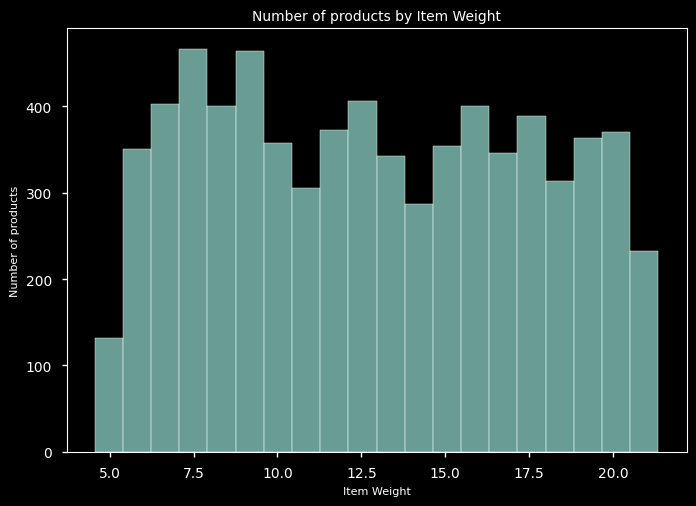

In [18]:
sns.histplot(data = df, x = 'Item_Weight')

#mean_value = np.mean(df)
#plt.axvline(mean_value, color='grey', linestyle='dashed', label=f'Mean: {mean_value:.2f}')

plt.title('Number of products by Item Weight', fontdict={'fontsize':10})
plt.xlabel('Item Weight', fontdict={'fontsize':8})
plt.ylabel('Number of products', fontdict={'fontsize':8});

#plt.legend()
plt.show()

- From the graph above it is clear that this column is equal to a wide range of values.

  - A suggestion is to simply drop the missing values. However, one has to consider the amount of data that will be lost, i.e. `17.17%`.

  - An alternate suggestion is to assume a value for the missing values.

Determine the mean and median:

In [19]:
print(df['Item_Weight'].mean())
print(df['Item_Weight'].median())

12.857645184135976
12.6


- The mean value for `Item_Weight` is `12.86` while the median value is `12.6`.
- I've decided to replace the missing values with the mean value:

In [20]:
mean_value = df['Item_Weight'].mean()
df['Item_Weight'] = df['Item_Weight'].fillna(mean_value)

- Lets check that the values for `Item_Weight` are updated:

In [21]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

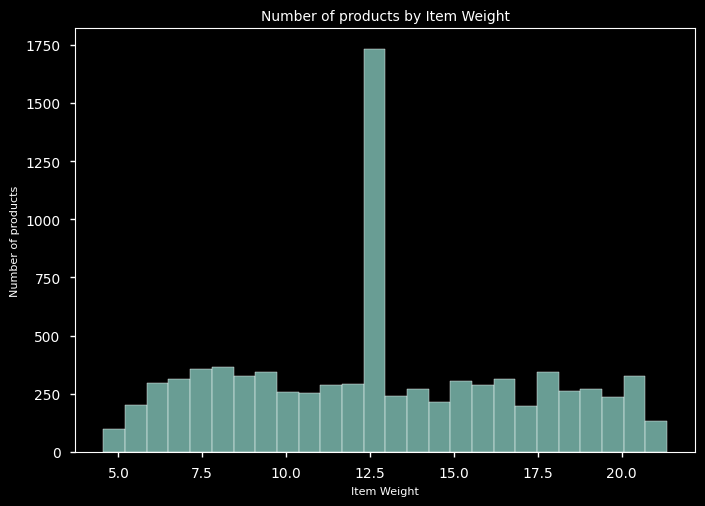

In [22]:
ax = sns.histplot(data = df, x = 'Item_Weight')
ax.set_title('Number of products by Item Weight', fontdict={'fontsize':10})
ax.set_xlabel('Item Weight', fontdict={'fontsize':8})
ax.set_ylabel('Number of products', fontdict={'fontsize':8});

*Outlet_Size:*

In [23]:
df['Outlet_Size'].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

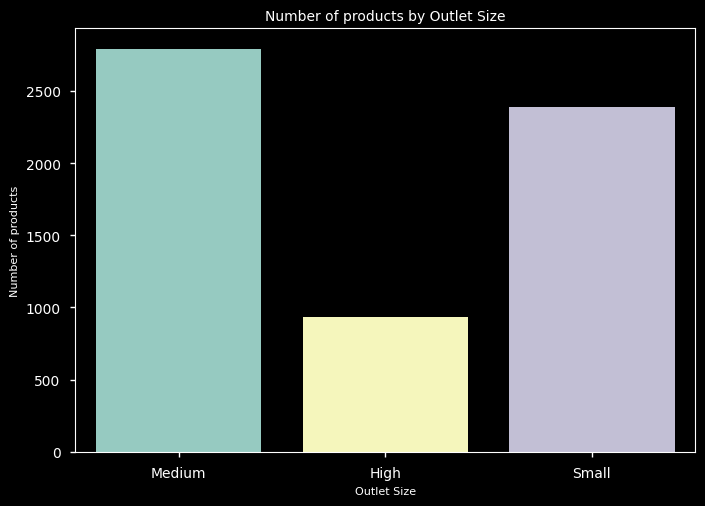

In [24]:
ax = sns.countplot(data = df, x = 'Outlet_Size')
ax.set_title('Number of products by Outlet Size', fontdict={'fontsize':10})
ax.set_xlabel('Outlet Size', fontdict={'fontsize':8})
ax.set_ylabel('Number of products', fontdict={'fontsize':8});

- This column assumes three values, i.e. Small, Medium and High.

  - I suggest to add a fourth value `Unknown` for the missing values.

In [25]:
df['Outlet_Size'] = df['Outlet_Size'].fillna(value = 'Unknown')

In [26]:
df['Outlet_Size'].value_counts()

Medium     2793
Unknown    2410
Small      2388
High        932
Name: Outlet_Size, dtype: int64

- Lets check that the values for `Outlet_Size` are updated, i.e. there are no missing values:

In [27]:
df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

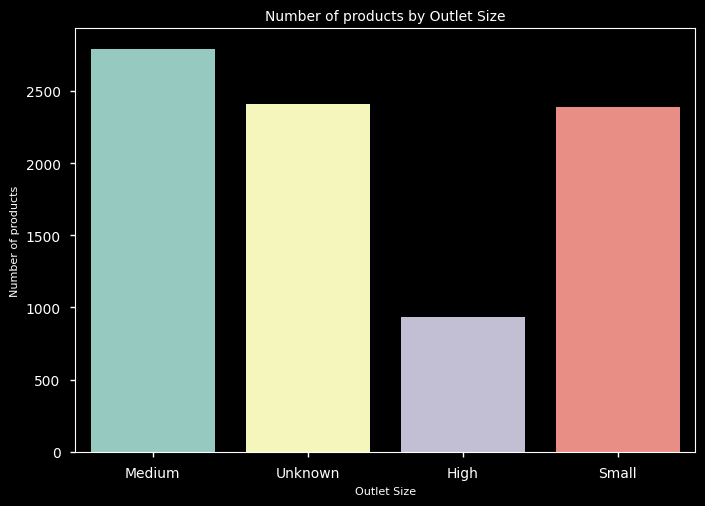

In [28]:
ax = sns.countplot(data = df, x = 'Outlet_Size')
ax.set_title('Number of products by Outlet Size', fontdict={'fontsize':10})
ax.set_xlabel('Outlet Size', fontdict={'fontsize':8})
ax.set_ylabel('Number of products', fontdict={'fontsize':8});

**Addressing data types**

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


- Data types appear as they should be.

**Addressing inconsistent categories of data**

We will look at all of the object type columns to inspect them further.

In [30]:
obj_columns = df.select_dtypes('object')
obj_columns

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDA15,Low Fat,Dairy,OUT049,Medium,Tier 1,Supermarket Type1
1,DRC01,Regular,Soft Drinks,OUT018,Medium,Tier 3,Supermarket Type2
2,FDN15,Low Fat,Meat,OUT049,Medium,Tier 1,Supermarket Type1
3,FDX07,Regular,Fruits and Vegetables,OUT010,Unknown,Tier 3,Grocery Store
4,NCD19,Low Fat,Household,OUT013,High,Tier 3,Supermarket Type1
...,...,...,...,...,...,...,...
8518,FDF22,Low Fat,Snack Foods,OUT013,High,Tier 3,Supermarket Type1
8519,FDS36,Regular,Baking Goods,OUT045,Unknown,Tier 2,Supermarket Type1
8520,NCJ29,Low Fat,Health and Hygiene,OUT035,Small,Tier 2,Supermarket Type1
8521,FDN46,Regular,Snack Foods,OUT018,Medium,Tier 3,Supermarket Type2


In [31]:
for i in obj_columns:
  print(i)
  print(df[i].value_counts())
  print('\n')

Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64


Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64


Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    55

- The following inconsistencies where found:

Item_Fat_Content:
  - `LF` should be `Low Fat`
  - `low fat` should be `Low Fat`
  - `reg` should be `Regular`

We address this below using a dictionary to replace the inconsistent categories.

In [32]:
current = ['Low Fat', 'Regular', 'LF', 'reg', 'low fat']
replacement = ['Low Fat', 'Regular', 'Low Fat', 'Regular', 'Low Fat']

rename_dict = dict(zip(current, replacement))
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace(rename_dict)

- Confirm that the inconsistent values have been addressed.

In [33]:
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

**Summary statistics for numerical columns**

In [34]:
df.describe().round(2)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.00,8523.00,8523.00,8523.00,8523.00
mean,12.86,0.07,140.99,1997.83,2181.29
std,4.23,0.05,62.28,8.37,1706.50
min,4.56,0.00,31.29,1985.00,33.29
25%,9.31,0.03,93.83,1987.00,834.25
50%,12.86,0.05,143.01,1999.00,1794.33
75%,16.00,0.09,185.64,2004.00,3101.30
max,21.35,0.33,266.89,2009.00,13086.96


In [35]:
stats =  df.describe().round(2)
stats.loc[['mean','min','max']]

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
mean,12.86,0.07,140.99,1997.83,2181.29
min,4.56,0.00,31.29,1985.00,33.29
max,21.35,0.33,266.89,2009.00,13086.96




---



## Exploratory Data Analysis

**Column by column**

We use custom functions to plot graphs per column.

In [36]:
num_cols = df.select_dtypes('number').columns
num_cols

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales'],
      dtype='object')

> We can exclude `Outlet_Establishment_Year` since the graphs will only show counts per year.

In [37]:
df['Outlet_Establishment_Year'].value_counts()

1985    1463
1987     932
1999     930
1997     930
2004     930
2002     929
2009     928
2007     926
1998     555
Name: Outlet_Establishment_Year, dtype: int64

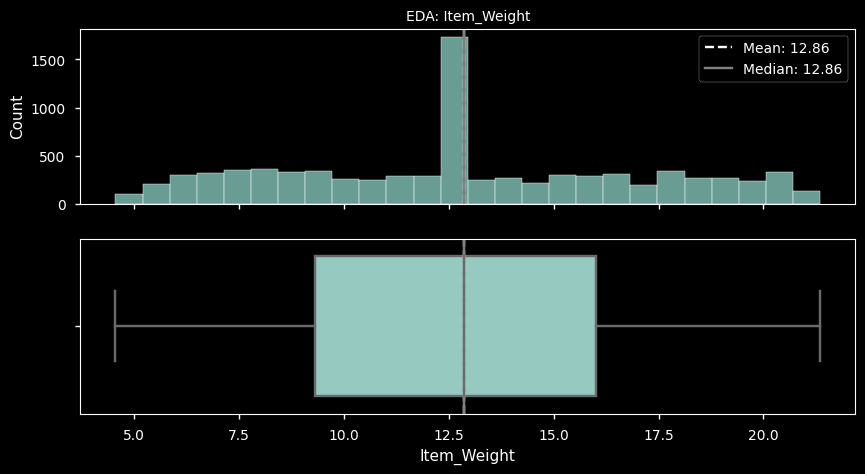

In [38]:
create_numeric_graphs(df,'Item_Weight')

> There seems to be no outliers in th Item_Weight field. Note that assuming the central value of the mean for the missing values in this column has resulted in the taller bar being higher.

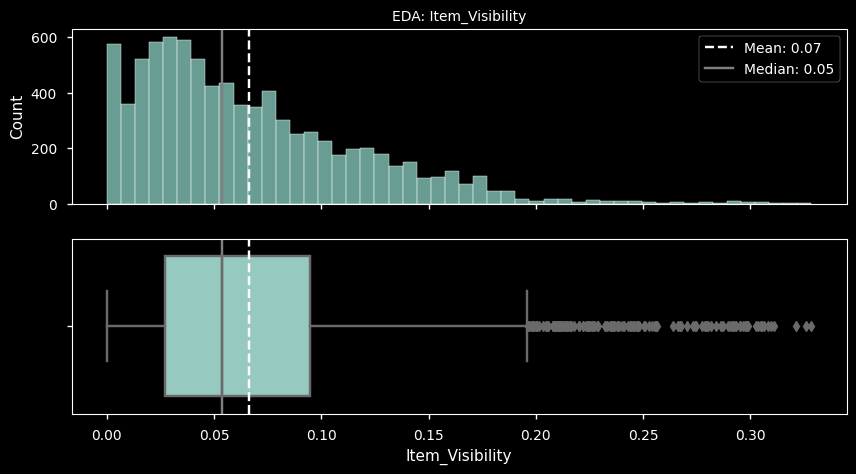

In [39]:
create_numeric_graphs(df,'Item_Visibility')

> From the boxplot we can see that there are several outliers in the Item_Visibility column. These may be valid data points, or they could be an error.

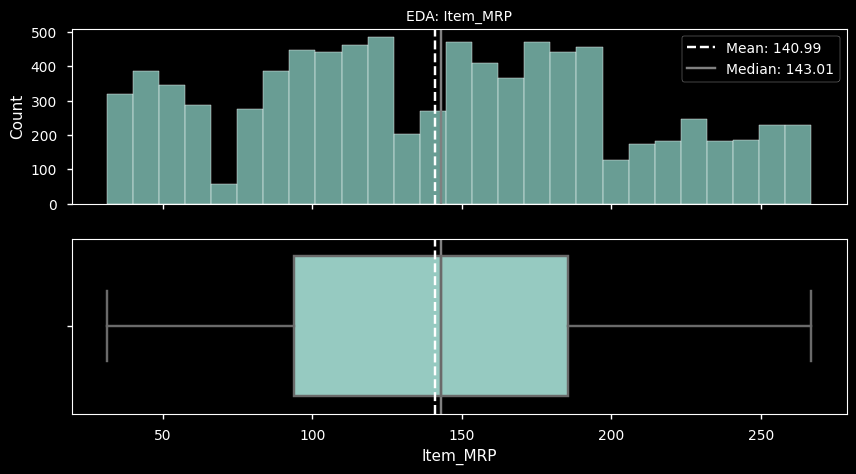

In [40]:
create_numeric_graphs(df,'Item_MRP')

> There seems to be no outliers in the Item_MRP field.

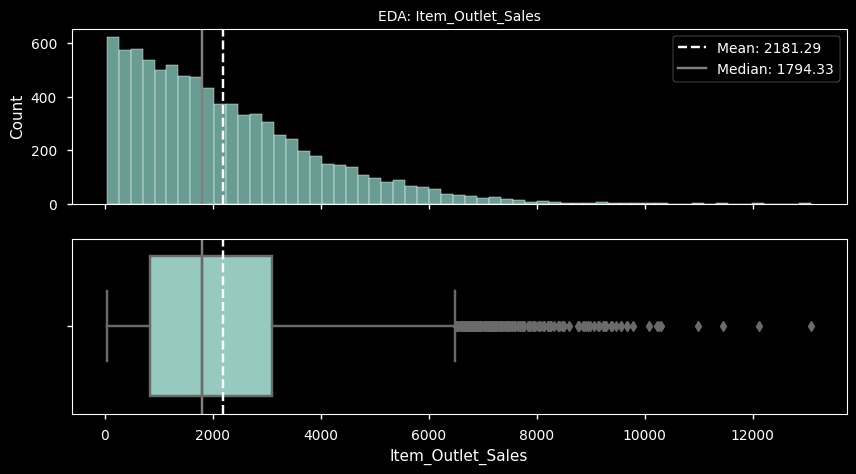

In [41]:
create_numeric_graphs(df,'Item_Outlet_Sales')

> From the boxplot we can see that there are several outliers in the Item_Outlet_Sales column. These may be valid data points, or they could be an error.

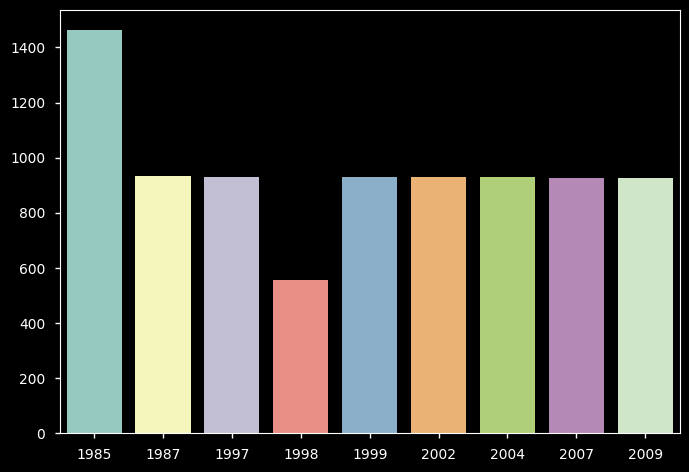

In [42]:
for_graph = df['Outlet_Establishment_Year'].value_counts().sort_values(ascending=False)
for_graph
ax = sns.barplot(x=for_graph.index, y=for_graph.values)

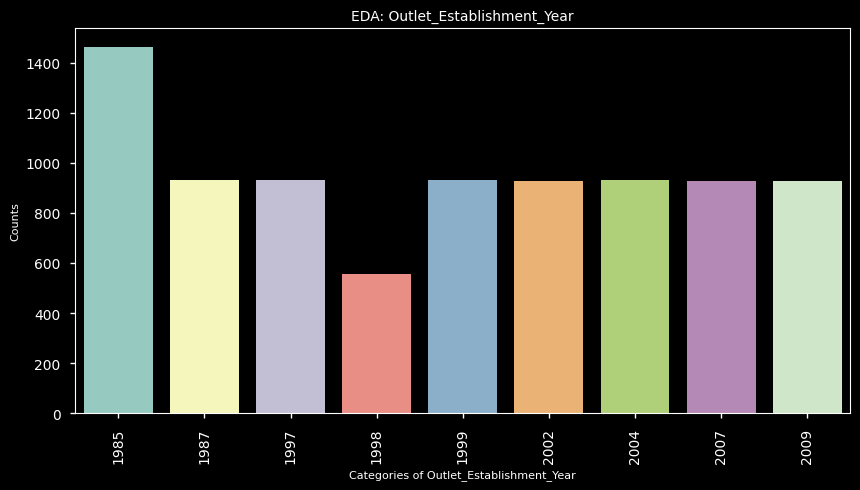

In [43]:
create_cat_graphs(df, 'Outlet_Establishment_Year')

> The highest counts are from stores established in `1985`.


In [44]:
obj_cols = df.select_dtypes('object').columns
obj_cols

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

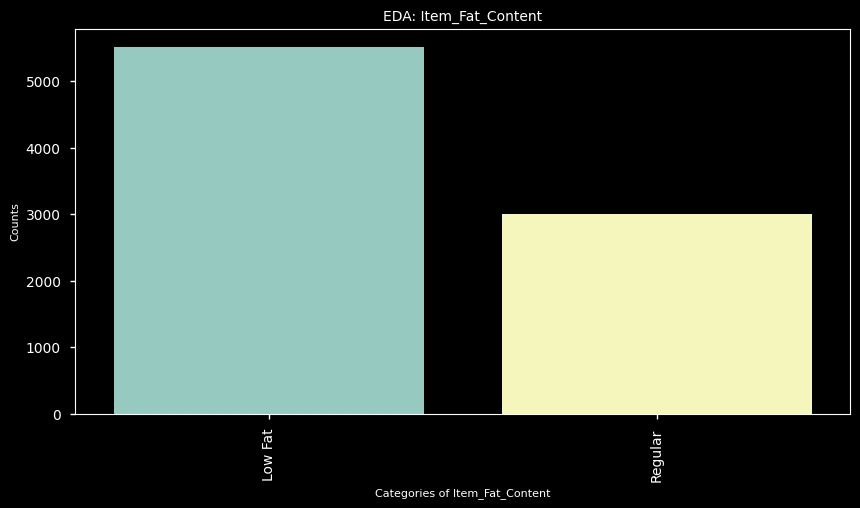

In [45]:
create_cat_graphs(df, 'Item_Fat_Content')

> The above graph illustrates that there are more Low Fat products than Regular products.

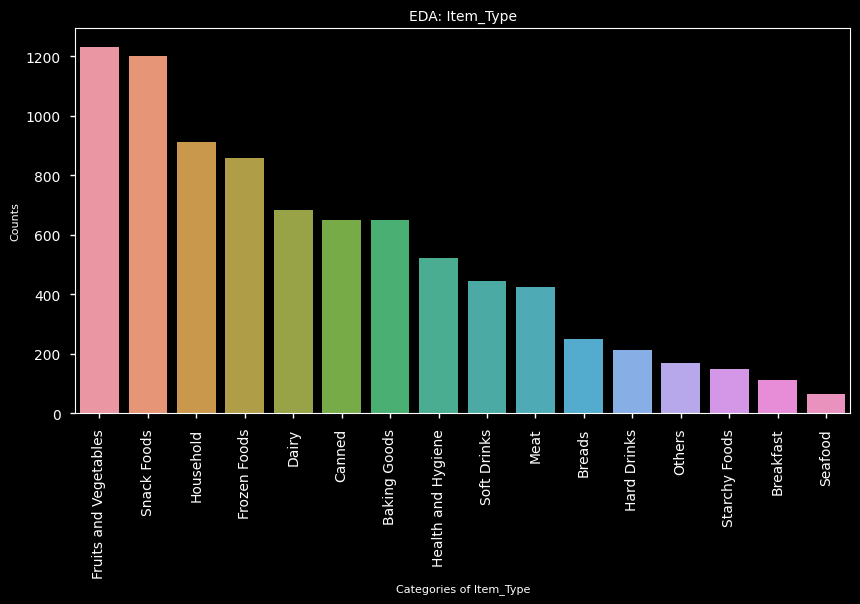

In [46]:
create_cat_graphs(df, 'Item_Type')

> We can deduce the top three item types from the graph above:
- `Fruits and vegetables`
- `Snack foods`
- `Household items`

> We also see that the item type with the least counts is `Seafood`.

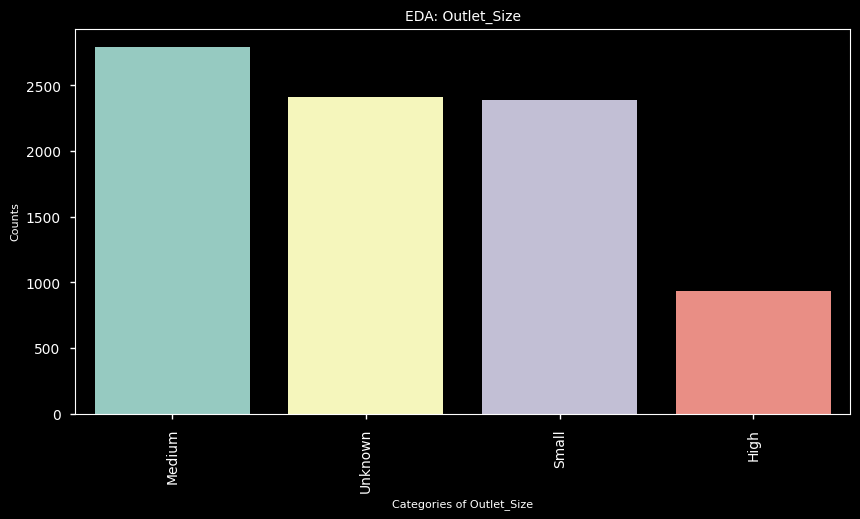

In [47]:
create_cat_graphs(df, 'Outlet_Size')

> Stores with a `Medium` size has the most counts with stores with a `High` size in terms of ground area covered has the least counts.

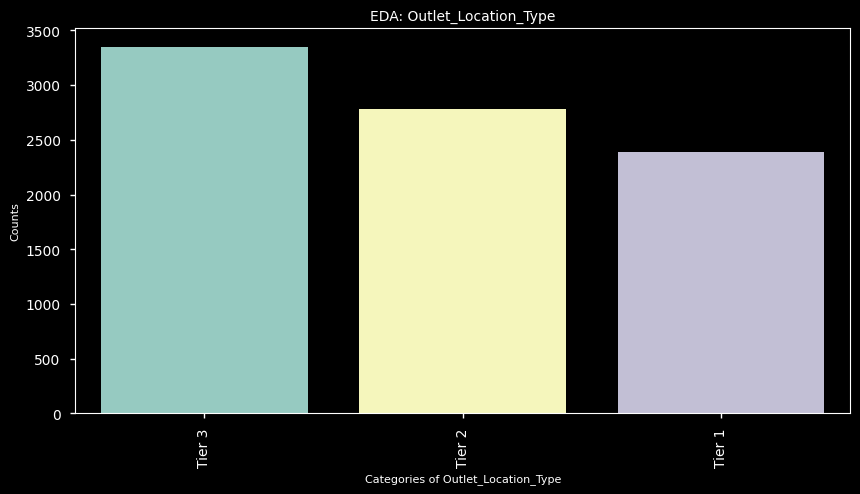

In [48]:
create_cat_graphs(df, 'Outlet_Location_Type')

`Tier 3` stores have the most counts while `Tier 1` stores have the least counts.

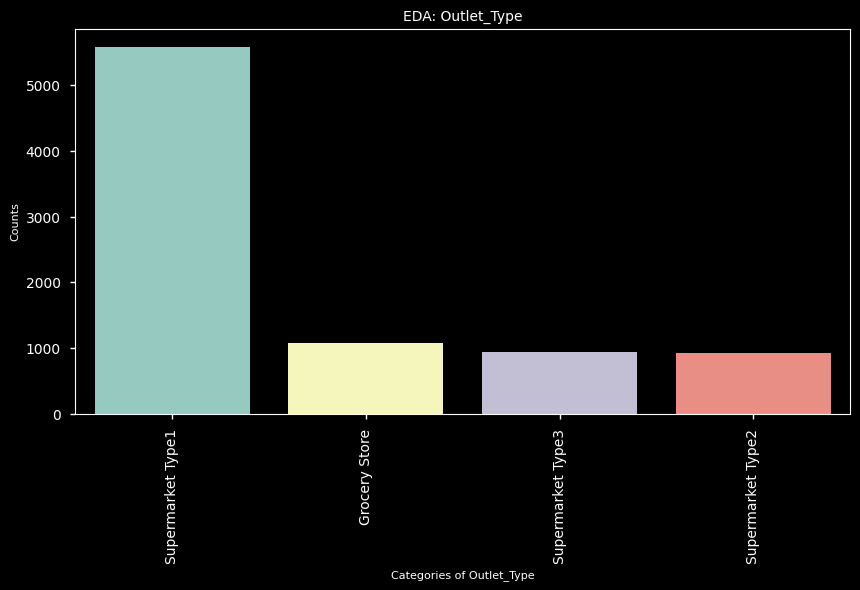

In [49]:
create_cat_graphs(df, 'Outlet_Type')

In [50]:
df['Outlet_Type'].value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

`Supermarket Type 1` have the most counts while `Supermarket Type 2 and Type 3` have the least counts (similar proportion).

**Correlations**

Correlations of all numeric columns:

In [51]:
corr = df.corr(numeric_only = True)
corr.round(2)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Weight,1.00,-0.01,0.02,-0.01,0.01
Item_Visibility,-0.01,1.00,-0.00,-0.07,-0.13
Item_MRP,0.02,-0.00,1.00,0.01,0.57
Outlet_Establishment_Year,-0.01,-0.07,0.01,1.00,-0.05
Item_Outlet_Sales,0.01,-0.13,0.57,-0.05,1.00


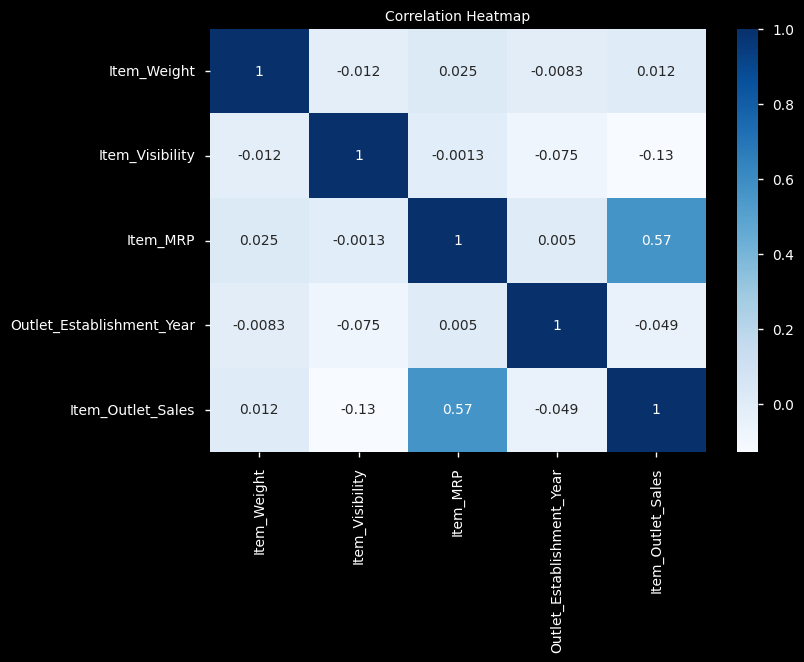

In [52]:
ax = sns.heatmap(corr, annot = True, cmap = 'Blues')
ax.set_title('Correlation Heatmap', fontdict={'fontsize':10});

> There seems to be a moderate positive correlation between
- `Item_MRP` and `Item_Outlet_Sales`

**We can also consider all fields at the same time as follows:**

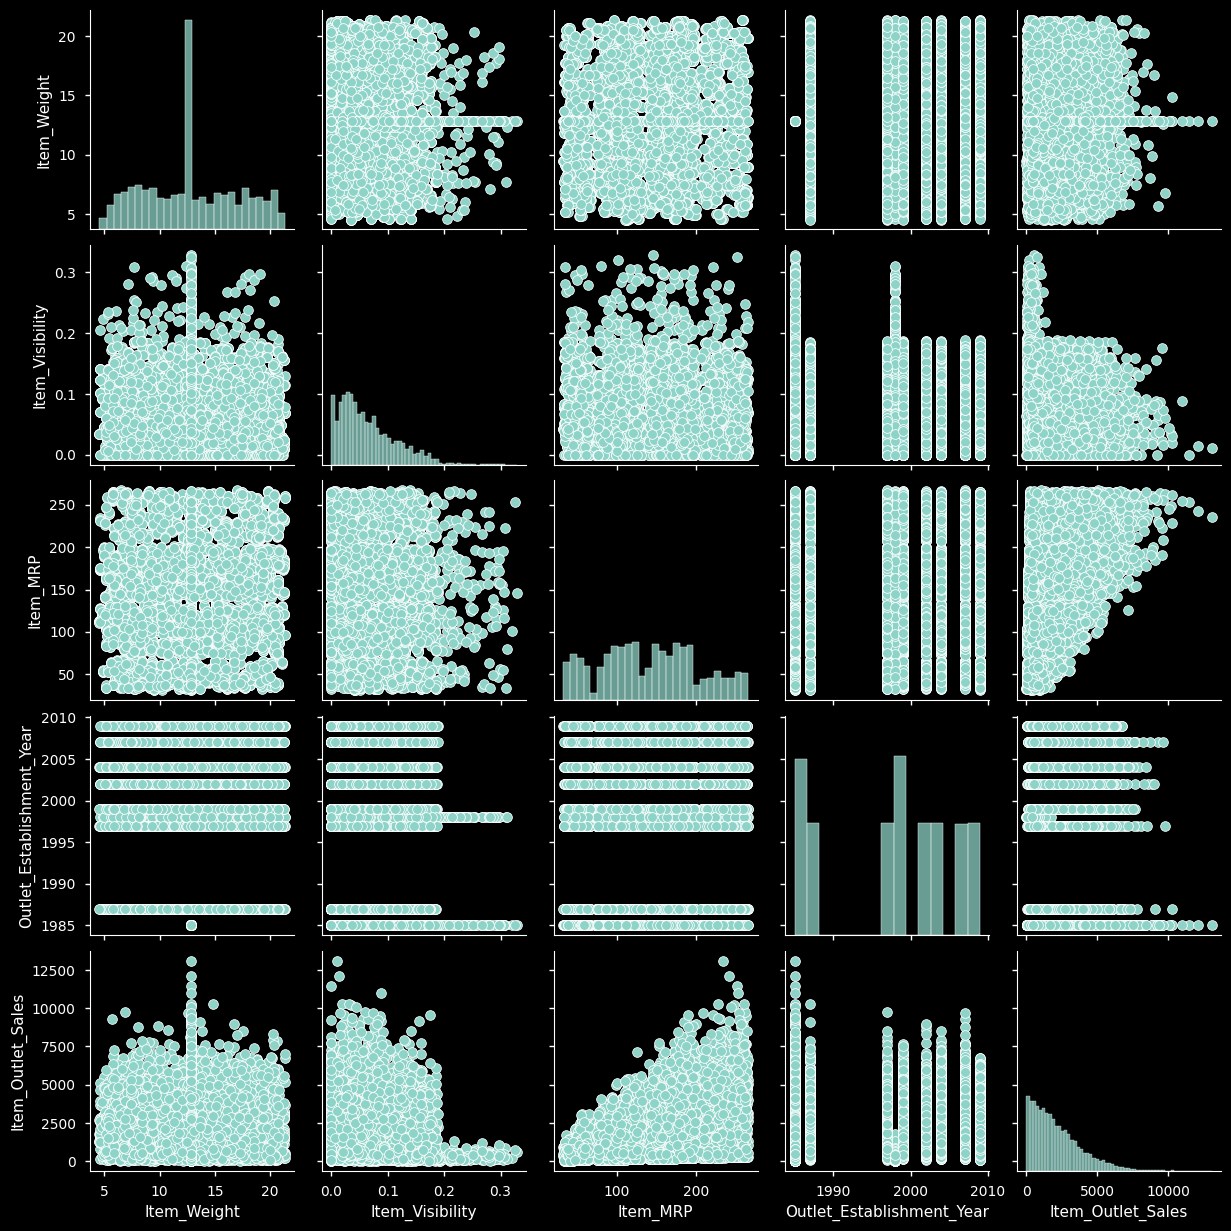

In [53]:
sns.pairplot(df);



---



## Preprocessing for machine learning

The goal of this step is to help the retailer by using machine learning to make predictions about future sales based on the data provided.

In [58]:
df2 = pd.read_csv(fpath)

## Clean Data

**Correcting data types:**

 > - Data types appear to be correct.

**Checking for duplicates:**

In [59]:
df2.duplicated().sum()

0

> - There are `no` duplicates in the data.

**Addressing inconsistent categories of data**

Consider columns with data type object:

In [60]:
obj_columns = df2.select_dtypes('object')
obj_columns

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDA15,Low Fat,Dairy,OUT049,Medium,Tier 1,Supermarket Type1
1,DRC01,Regular,Soft Drinks,OUT018,Medium,Tier 3,Supermarket Type2
2,FDN15,Low Fat,Meat,OUT049,Medium,Tier 1,Supermarket Type1
3,FDX07,Regular,Fruits and Vegetables,OUT010,NaN,Tier 3,Grocery Store
4,NCD19,Low Fat,Household,OUT013,High,Tier 3,Supermarket Type1
...,...,...,...,...,...,...,...
8518,FDF22,Low Fat,Snack Foods,OUT013,High,Tier 3,Supermarket Type1
8519,FDS36,Regular,Baking Goods,OUT045,NaN,Tier 2,Supermarket Type1
8520,NCJ29,Low Fat,Health and Hygiene,OUT035,Small,Tier 2,Supermarket Type1
8521,FDN46,Regular,Snack Foods,OUT018,Medium,Tier 3,Supermarket Type2


In [61]:
for i in obj_columns:
  print(i)
  print(df2[i].value_counts())
  print('\n')

Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64


Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64


Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    55

The following inconsistencies where found:

*Item_Fat_Content:*
  - `LF` should be `Low Fat`
  - `low fat` should be `Low Fat`
  - `reg` should be `Regular`

We address this below using a dictionary to replace the inconsistent categories.

In [62]:
current = ['Low Fat', 'Regular', 'LF', 'reg', 'low fat']
replacement = ['Low Fat', 'Regular', 'Low Fat', 'Regular', 'Low Fat']

rename_dict = dict(zip(current, replacement))
df2['Item_Fat_Content'] = df['Item_Fat_Content'].replace(rename_dict)

Confirm that the inconsistent values have been addressed:

In [63]:
df2['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

All inconsistencies have been addressed.

**Summary statistics of numerical columns**

In [64]:
stats =  df2.describe().round(2)
stats.loc[['mean','min','max']]

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
mean,12.86,0.07,140.99,1997.83,2181.29
min,4.56,0.00,31.29,1985.00,33.29
max,21.35,0.33,266.89,2009.00,13086.96


> - There seems to be `no` constant numeric values.

**Check for unique entries in columns**

Consider columns with data type object:

In [65]:
for i in obj_columns:
  print(i)
  print(df2[i].nunique())
  print(f'{round(df2[i].nunique()/len(df2)*100,2)}%')
  print('\n')

Item_Identifier
1559
18.29%


Item_Fat_Content
2
0.02%


Item_Type
16
0.19%


Outlet_Identifier
10
0.12%


Outlet_Size
3
0.04%


Outlet_Location_Type
3
0.04%


Outlet_Type
4
0.05%




> - `No` column has unique values.
> - `Item_Identifier`, `Item_Type`, `Outlet_Identifier` have high cardinality.

**Drop unwanted columns**

> - Drop `Item_Identifier` and `Outlet_Identifier` due to high cardinality.
> - `Item_Type` seems to be valuable based on understanding.
> - Drop `Outlet_Establishment_Year` as the stakeholders have no influence over this.

In [66]:
drop_cols = ['Item_Identifier', 'Outlet_Identifier', 'Outlet_Establishment_Year']
df2 = df2.drop(columns = drop_cols)

## Feature by feature inspection

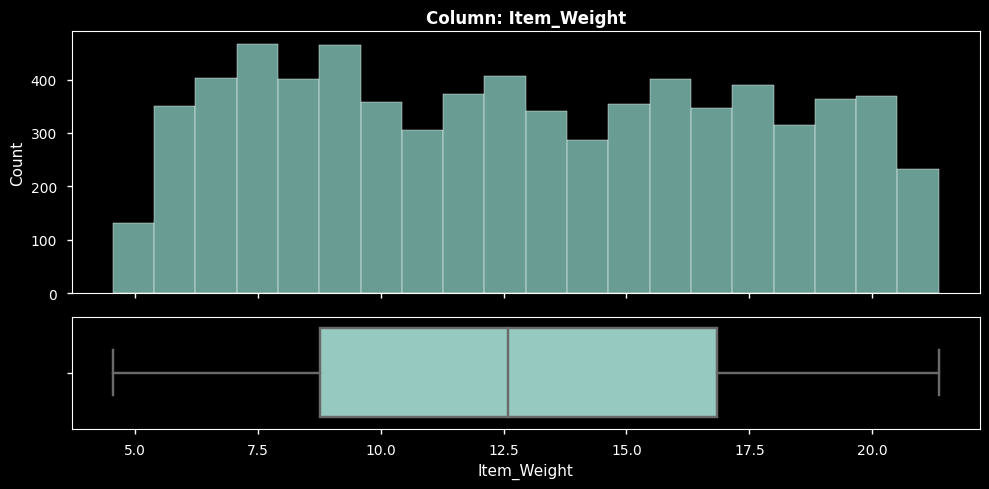

- NaN's Found: 1463 (17.17%)
- Unique Values: 415
- Most common value: 'nan' occurs 1463 times (17.17%)
- Not constant or quasi-constant.


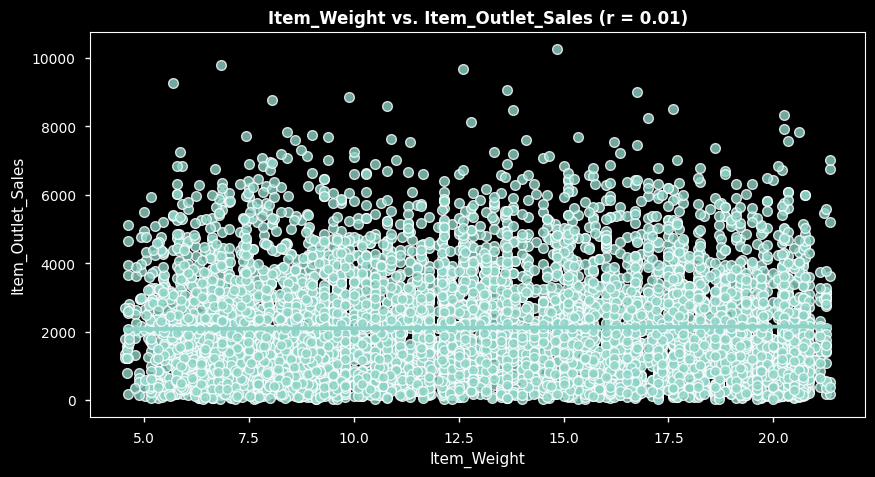

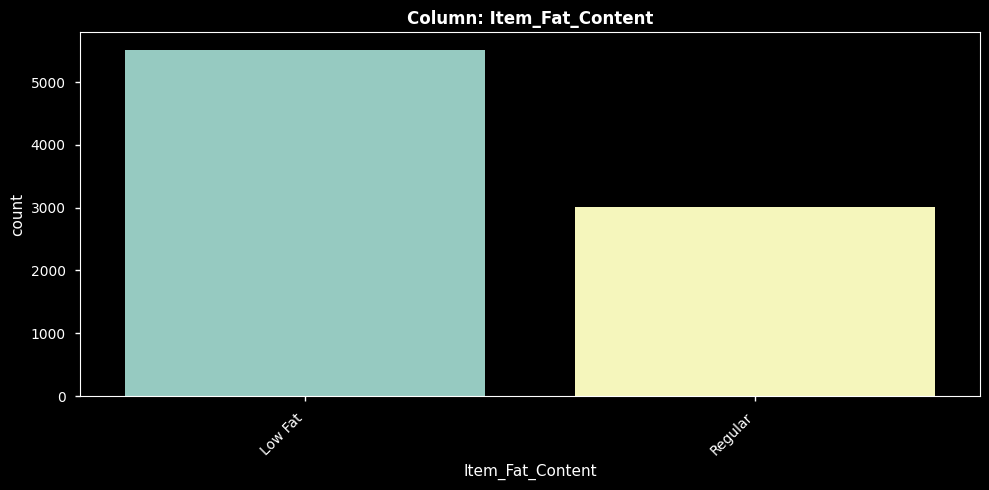

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: 'Low Fat' occurs 5517 times (64.73%)
- Not constant or quasi-constant.


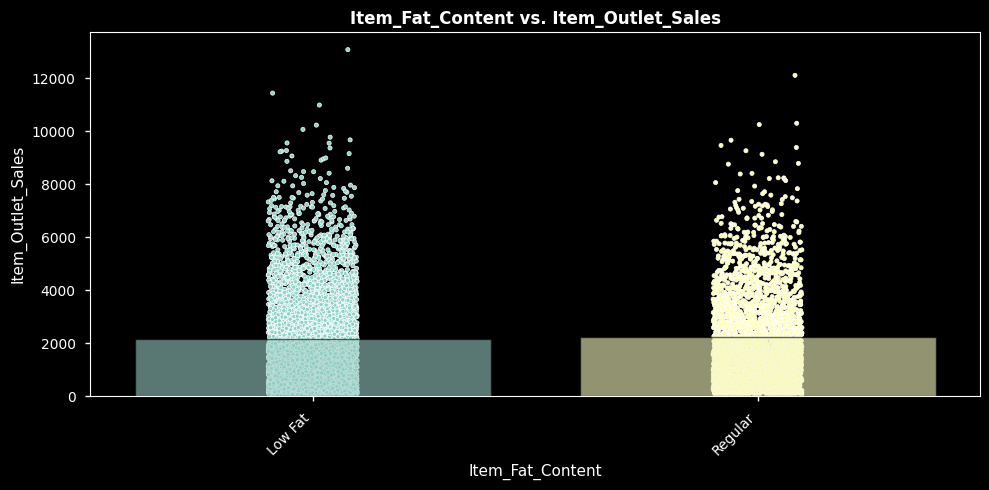

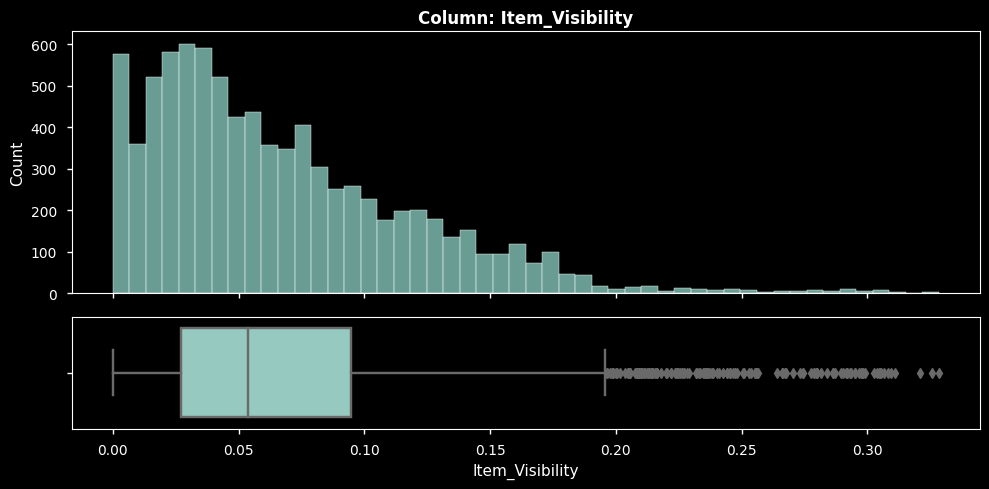

- NaN's Found: 0 (0.0%)
- Unique Values: 7880
- Most common value: '0.0' occurs 526 times (6.17%)
- Not constant or quasi-constant.


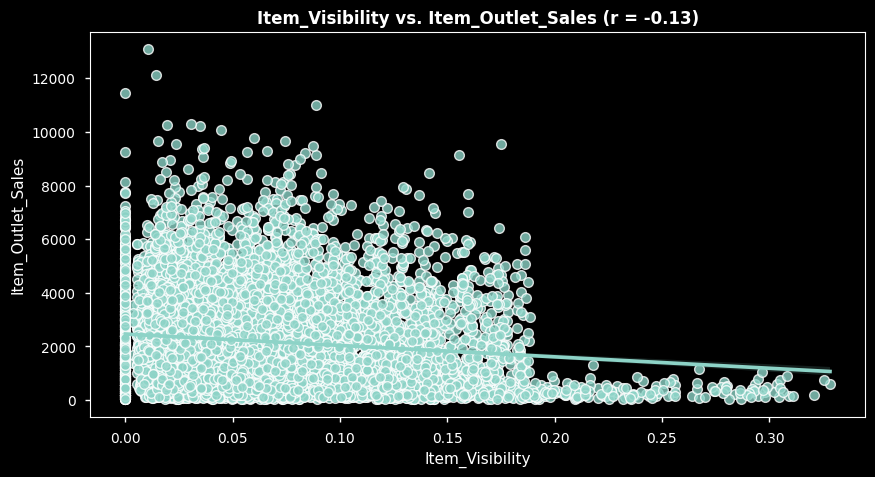

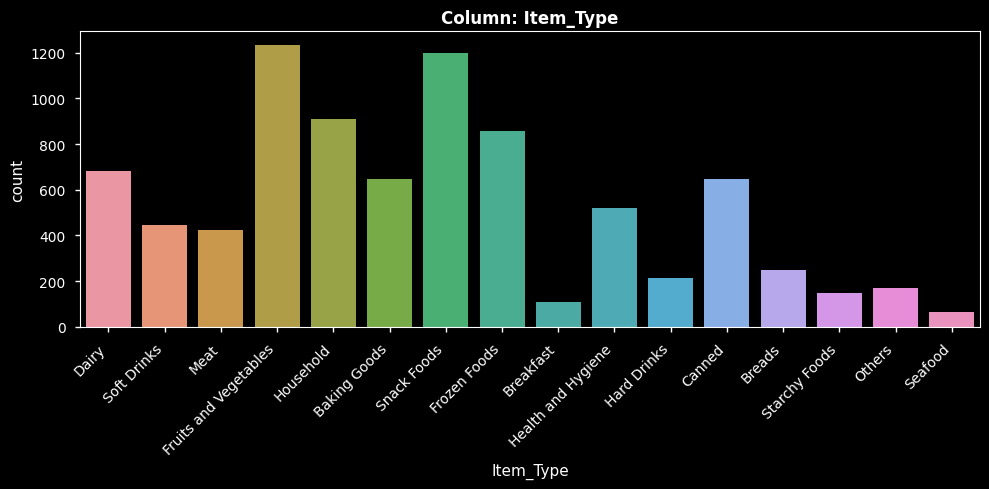

- NaN's Found: 0 (0.0%)
- Unique Values: 16
- Most common value: 'Fruits and Vegetables' occurs 1232 times (14.46%)
- Not constant or quasi-constant.


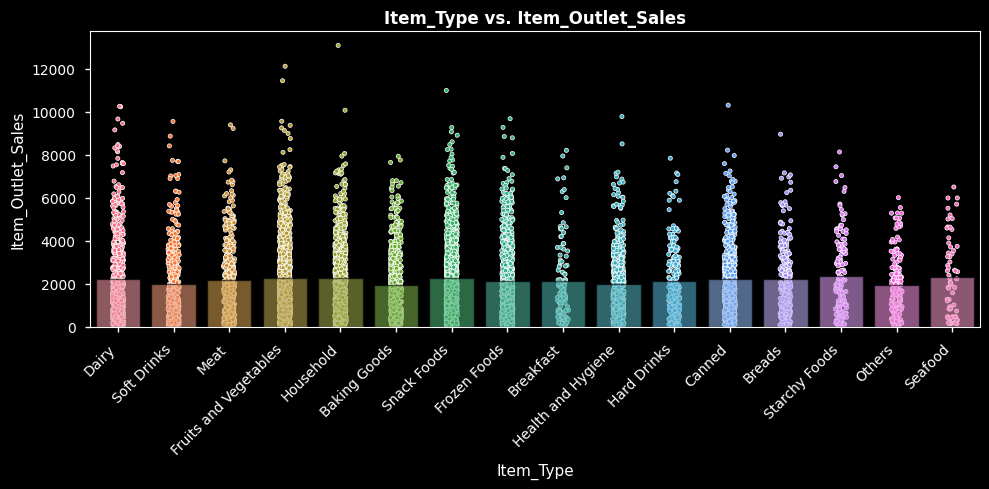

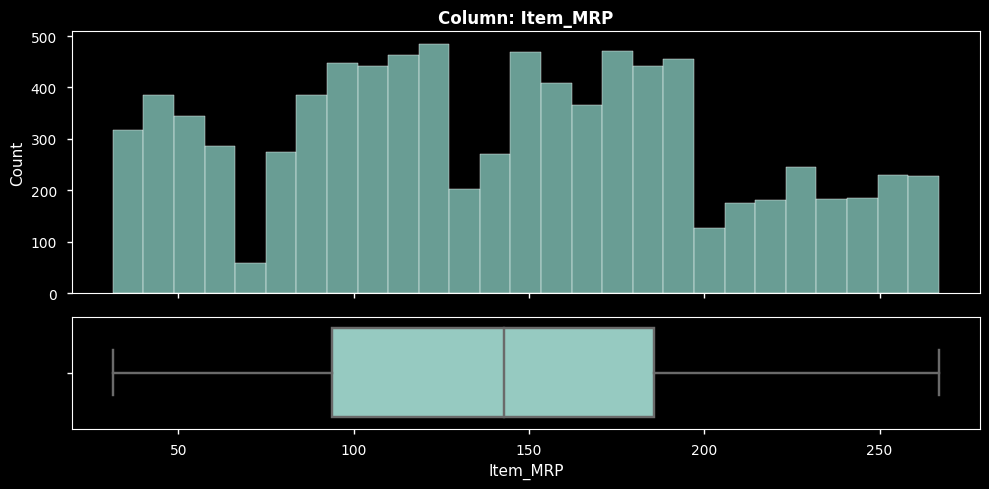

- NaN's Found: 0 (0.0%)
- Unique Values: 5938
- Most common value: '172.0422' occurs 7 times (0.08%)
- Not constant or quasi-constant.


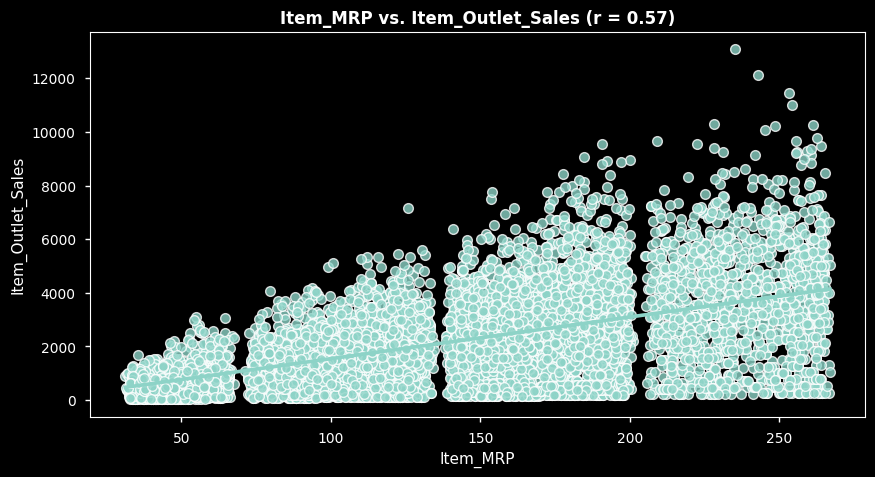

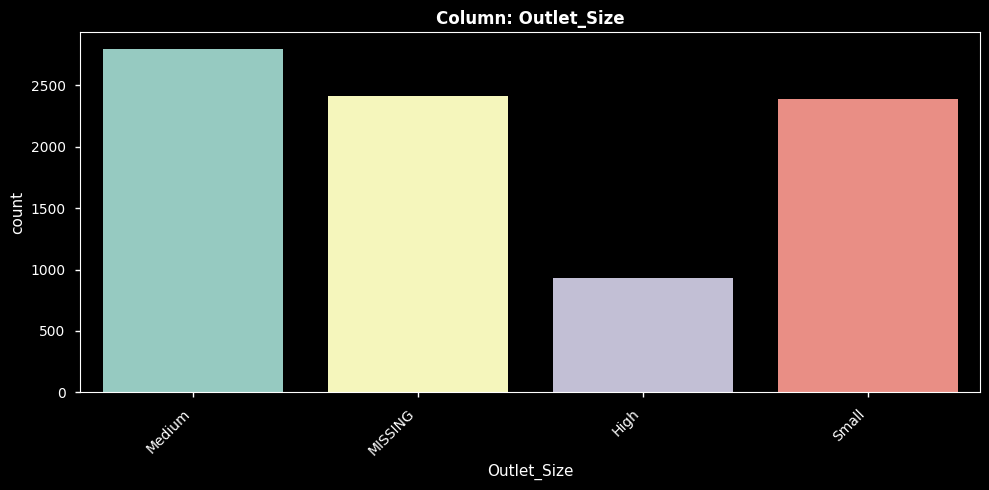

- NaN's Found: 2410 (28.28%)
- Unique Values: 4
- Most common value: 'Medium' occurs 2793 times (32.77%)
- Not constant or quasi-constant.


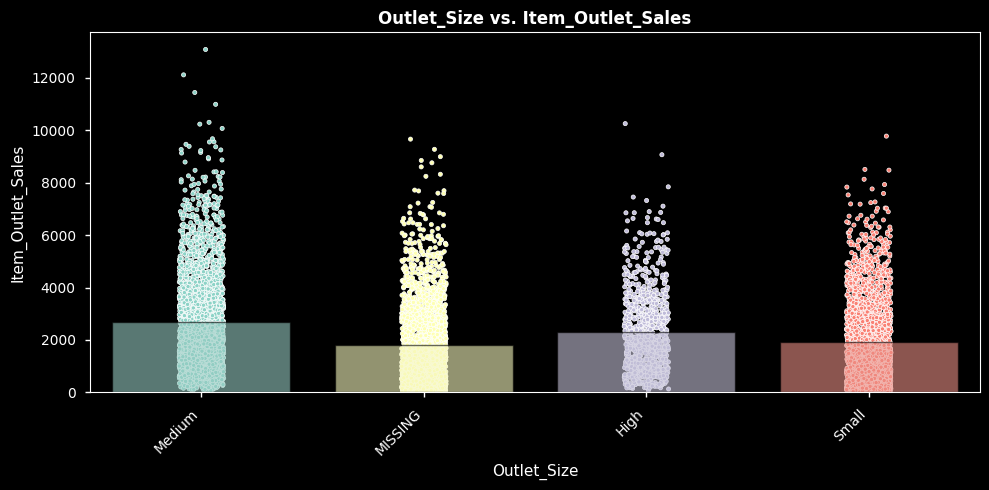

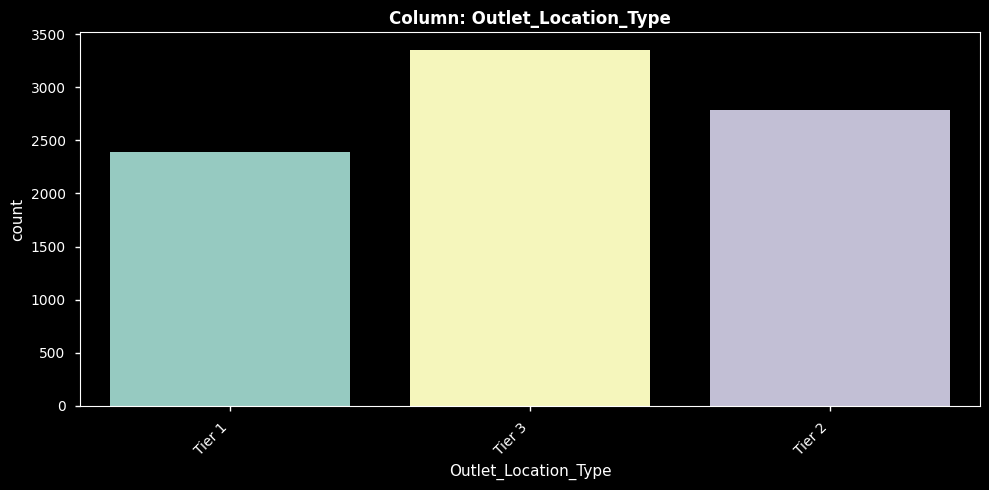

- NaN's Found: 0 (0.0%)
- Unique Values: 3
- Most common value: 'Tier 3' occurs 3350 times (39.31%)
- Not constant or quasi-constant.


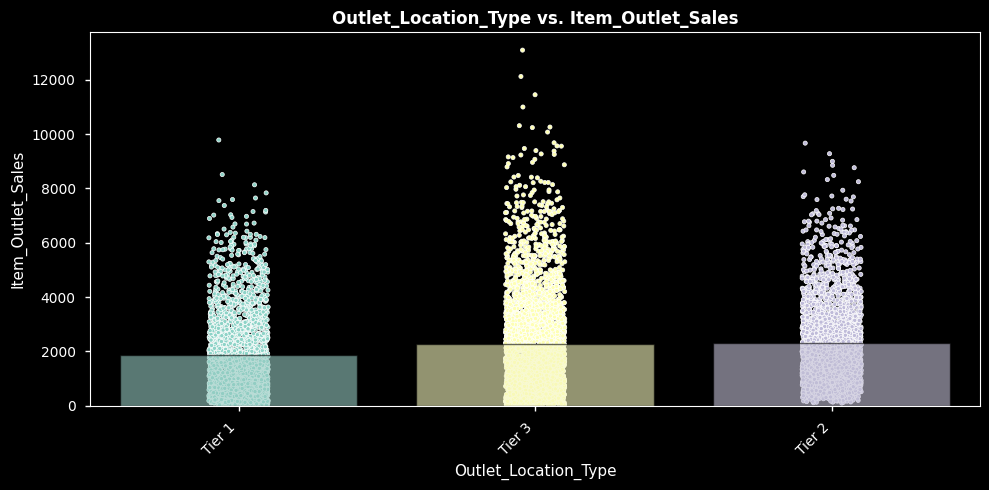

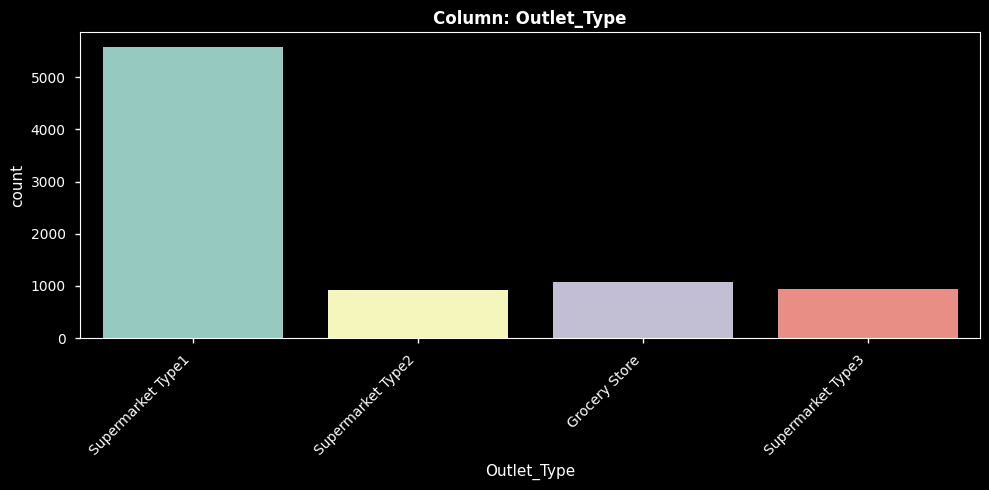

- NaN's Found: 0 (0.0%)
- Unique Values: 4
- Most common value: 'Supermarket Type1' occurs 5577 times (65.43%)
- Not constant or quasi-constant.


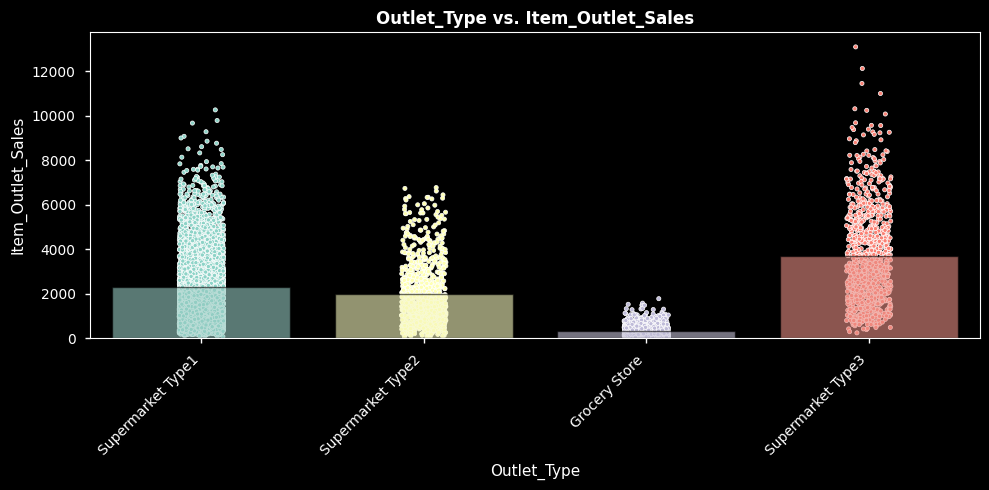

In [109]:
target = 'Item_Outlet_Sales'

for feature in df2.columns.drop(target):

  if pd.api.types.is_numeric_dtype(df2[feature]):
    explore_numeric(df2, feature);
    plot_numeric_vs_target(df2, feature, target);

  else:
    explore_categorical(df2, feature);
    plot_categorical_vs_target(df2, feature, target);

## Train test split

Our target vector (y) will be the *Item_Outlet_Sales* column.

In [68]:
y = df2['Item_Outlet_Sales']

Our feature matrix (X) will be the rest of the features.

In [69]:
X = df2.drop(columns = 'Item_Outlet_Sales')

Then, train\test split the data:

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Column Transformer

**Preprocessing numeric features**

Create a list of numeric columns

In [71]:
num_cols = X_train.select_dtypes("number").columns
num_cols

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP'], dtype='object')

Instantiate preprocessors

In [72]:
impute_mean = SimpleImputer(strategy='mean')
scaler = StandardScaler()

Create a numeric preprocessing pipeline

In [73]:
num_pipe = make_pipeline(impute_mean, scaler)
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

Create a numeric tuple for ColumnTransformer

In [74]:
num_tuple = ('numeric', num_pipe, num_cols)
num_tuple

('numeric',
 Pipeline(steps=[('simpleimputer', SimpleImputer()),
                 ('standardscaler', StandardScaler())]),
 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP'], dtype='object'))

**Preprocessing ordinal features**

Create a list of ordinal columns

In [75]:
ord_cols = ['Outlet_Size']

Instantiate preprocesser to impute ordinal data

In [76]:
impute_na_ord = SimpleImputer(strategy='constant', fill_value='Unknown')

- Specify the order of categories in the *Outlet_Size* column

In [77]:
outlet_size_order = ['Unknown', 'Small','Medium', 'High']

Instantiate preprocessors

In [78]:
ordinal_category_orders = [outlet_size_order]
ord_encoder = OrdinalEncoder(categories=ordinal_category_orders)

scaler_ord = StandardScaler()

Create an ordinal preprocessing pipeline

In [79]:
ord_pipe = make_pipeline(impute_na_ord, ord_encoder, scaler_ord)
ord_pipe

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='Unknown', strategy='constant')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['Unknown', 'Small', 'Medium',
                                             'High']])),
                ('standardscaler', StandardScaler())])

Create an ordinal tuple for ColumnTransformer

In [80]:
ord_tuple = ('ordinal', ord_pipe, ord_cols)
ord_tuple

('ordinal',
 Pipeline(steps=[('simpleimputer',
                  SimpleImputer(fill_value='Unknown', strategy='constant')),
                 ('ordinalencoder',
                  OrdinalEncoder(categories=[['Unknown', 'Small', 'Medium',
                                              'High']])),
                 ('standardscaler', StandardScaler())]),
 ['Outlet_Size'])

**Preprocessing categorical (nominal) features**

Create a list of categorical columns

In [81]:
ohe_cols = X_train.select_dtypes('object').drop(columns=ord_cols).columns
ohe_cols

Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type', 'Outlet_Type'], dtype='object')

Instantiate preprocessors

In [82]:
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

Create a categorical tuple for ColumnTransformer

In [83]:
ohe_tuple = ('categorical', ohe_encoder, ohe_cols)
ohe_tuple

('categorical',
 OneHotEncoder(handle_unknown='ignore', sparse_output=False),
 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type', 'Outlet_Type'], dtype='object'))

**Instantiate the ColumnTransformer**

In [86]:
preprocessor = ColumnTransformer([num_tuple, ord_tuple, ohe_tuple],
                                    verbose_feature_names_out=False)

**Fit the ColumnTransformer on training data only**

In [87]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP'], dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='Unknown',
                                                                strategy='constant')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Unknown',
                                                                              'Small',
                                                                              'Medium',
                                                                              'High']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Outlet_Size']),
                                ('categorical',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type', 'Outlet_Type'], dtype='object'))],
                  verbose_feature_names_out=False)

**Transform the data**

* Training data:

In [88]:
X_train_processed = preprocessor.transform(X_train)

* Testing data:

In [89]:
X_test_processed = preprocessor.transform(X_test)

* Let's view the processed training data:

In [90]:
X_train_processed.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Size,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,...,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
4776,0.817249,-0.712775,1.828109,0.748125,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7510,0.556340,-1.291052,0.603369,0.748125,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5828,-0.131512,1.813319,0.244541,0.748125,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5327,-1.169219,-1.004931,-0.952591,-0.264370,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4810,1.528819,-0.965484,-0.336460,-1.276865,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


## Check the transformed training data

Confirm that all columns are numeric.

In [91]:
X_train_processed.dtypes

Item_Weight                        float64
Item_Visibility                    float64
Item_MRP                           float64
Outlet_Size                        float64
Item_Fat_Content_Low Fat           float64
Item_Fat_Content_Regular           float64
Item_Type_Baking Goods             float64
Item_Type_Breads                   float64
Item_Type_Breakfast                float64
Item_Type_Canned                   float64
Item_Type_Dairy                    float64
Item_Type_Frozen Foods             float64
Item_Type_Fruits and Vegetables    float64
Item_Type_Hard Drinks              float64
Item_Type_Health and Hygiene       float64
Item_Type_Household                float64
Item_Type_Meat                     float64
Item_Type_Others                   float64
Item_Type_Seafood                  float64
Item_Type_Snack Foods              float64
Item_Type_Soft Drinks              float64
Item_Type_Starchy Foods            float64
Outlet_Location_Type_Tier 1        float64
Outlet_Loca

* All columns are `numeric`.

Confirm that the original numeric features have been scaled.

Consider the mean, standard deviation, min, and max for numeric columns:

In [92]:
stats =  X_train_processed.describe().round(2)
stats.loc[['mean','std','min','max']]

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Size,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,...,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
mean,0.00,-0.00,0.00,0.00,0.65,0.35,0.07,0.03,0.01,0.08,...,0.14,0.05,0.02,0.27,0.33,0.40,0.12,0.65,0.11,0.11
std,1.00,1.00,1.00,1.00,0.48,0.48,0.26,0.16,0.11,0.26,...,0.35,0.22,0.14,0.45,0.47,0.49,0.33,0.48,0.31,0.32
min,-1.98,-1.29,-1.77,-1.28,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,2.00,5.13,1.99,1.76,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


For `original numeric` columns:
* The mean is `~ 0`.
* The standard deviation is `~ 1`.
Thus, the data has been scaled.



---



## Machine Learning

## Linear Regression Model

Create a model pipeline

In [93]:
linreg = LinearRegression()

linreg_pipe = make_pipeline(preprocessor, linreg)

Fit the model pipeline on the training data

In [94]:
linreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP'], dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('ordinalenco...
                                                                   OrdinalEncoder(categories=[['Unknown',
                                                                                               'Small',
                                                                                               'Medium',
                                                                                               'High']])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Outlet_Size']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type', 'Outlet_Type'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('linearregression', LinearRegression())])

Evaluate the model

In [95]:
evaluate_regression(linreg_pipe, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 847.145
- MSE = 1,299,210.393
- RMSE = 1,139.829
- R^2 = 0.561

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 806.530
- MSE = 1,199,144.239
- RMSE = 1,095.054
- R^2 = 0.565


> - The r<sup>2</sup> for the training and test data is `0.561` and `0.565` respectively.
> - This suggests that the model is explaining around 50% of the variability in the data.
> - This may indicate a balance between underfitting (high bias) and overfitting (high variance).
> - Since both data sets provided similar results, it may suggest consistency in model performance.

## Random Forest Model

Create a model pipeline

In [96]:
rfreg = RandomForestRegressor(random_state=42)

rf_pipe = make_pipeline(preprocessor, rfreg)

Fit the model pipeline on the training data

In [97]:
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP'], dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('ordinalenco...
                                                                                               'Small',
                                                                                               'Medium',
                                                                                               'High']])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Outlet_Size']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type', 'Outlet_Type'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

Evaluate the model

In [98]:
evaluate_regression(rf_pipe, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 299.953
- MSE = 187,247.959
- RMSE = 432.722
- R^2 = 0.937

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 776.594
- MSE = 1,258,519.493
- RMSE = 1,121.838
- R^2 = 0.544


> - The r<sup>2</sup> for the training and test data is `0.937` and `0.544` respectively.
> - This suggests that the model is `overfitting` due to the high training r<sup>2</sup> value.
> - The test r<sup>2</sup> indicates that the model explains around 50% of the variability in the test data.
> - Thus, there is some predictive capability on unseen data.

> - The `linear regression` model is the preferred model since it is more balanced.
>- Even though the r<sup>2</sup> is higher for the training data using the random forest model, the drop in performance on the test data indicates that the random forest model is not performing as well as the linear regression model.  

## Use GridSearchCV to tune the Random Forest Model

Consider parameters:

In [99]:
rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['Item_Weight', 'Item_Visibility', 'Item_MRP'], dtype='object')),
                                   ('ordinal',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(fill_value='Unknown',
                                                                   strategy='constant')),
                                                    ('ordinalencoder',
                                                     OrdinalEncoder(categories=[['Unknown',
                                                  

Define parameter grid

In [100]:
param_grid = {'randomforestregressor__max_depth': [None,10,15,20],
          'randomforestregressor__n_estimators':[10,100,150,200],
          'randomforestregressor__min_samples_leaf':[2,3,4],
          'randomforestregressor__max_features':['sqrt','log2',None]
          }

Instantiate GridSearchCV

In [101]:
grid_search = GridSearchCV(rf_pipe, param_grid, cv=2, verbose=1)

Fit to training data

In [102]:
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 144 candidates, totalling 288 fits


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Item_Weight', 'Item_Visibility', 'Item_MRP'], dtype='object')),
                                                                        ('ordinal',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(fill_value='Unknown',
                                                                                                        strateg...
                                                                         Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type', 'Outlet_Type'], dtype='object'))],
                                                          verbose_feature_names_out=False)),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'randomforestregressor__max_depth': [None, 10, 15, 20],
                         'randomforestregressor__max_features': ['sqrt', 'log2',
                                                                 None],
                         'randomforestregressor__min_samples_leaf': [2, 3, 4],
                         'randomforestregressor__n_estimators': [10, 100, 150,
                                                                 200]},
             verbose=1)

Return the optimal parameter values:

In [103]:
grid_search.best_params_

{'randomforestregressor__max_depth': 10,
 'randomforestregressor__max_features': None,
 'randomforestregressor__min_samples_leaf': 4,
 'randomforestregressor__n_estimators': 200}

Define the best version of the model

In [104]:
best_rf = grid_search.best_estimator_

Evaluate the best version of the model

In [105]:
evaluate_regression(best_rf, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 662.941
- MSE = 895,161.158
- RMSE = 946.130
- R^2 = 0.698

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 735.963
- MSE = 1,116,665.330
- RMSE = 1,056.724
- R^2 = 0.595


>- The r<sup>2</sup> for the training data decreased from `0.937` to `0.698` indicating that the tuned model is less prone to overfitting.
> - The r<sup>2</sup> for the test data improved slightly from `0.544` to `0.595` indicating that the tuned model performs better on unseen data, compared to the default model, i.e. better generalization.
> - Thus, tuning `improved` the random forest models performance.



---



## Recommendation

Overall, which model do you recommend?
> - The `tuned random forest model`: The r<sup>2</sup> for the test data (`0.595`) is higher than that of the linear regression model (`0.565`), indicating better generalization and predictive performance on unseen data.

For non-technical stakeholder:

>- The random forest regression model is able to accurately explain 60% of the variability in the data, i.e. our models prediction matches actual outcomes 60% of the time.

> - Also consider the RMSE (Root Mean Squared Error) becuase it is easy to interpret and accounts for the size of prediction errors.

> - On average, the model's predictions are off by `1 057 (rounded)` units compared to the actual values.

To what extent is this model overfit/underfit?
> - The r<sup>2</sup> on the training data (`0.698`) is higher than on the test data (`0.595`). However the gap is not too large and may be expected.
> - The MSE (Mean Squared Error) on the training data (`895 161`) is 25% lower than the MSE (`1 116 665`) on the test data. This may indicate that the model is fitting the training data too well.
> - The model may be `overfit`.